<a href="https://colab.research.google.com/github/fromofrancishaba/2024_Cours_Projet_Statistique_Sous_R_ENSAE/blob/main/FRANCIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

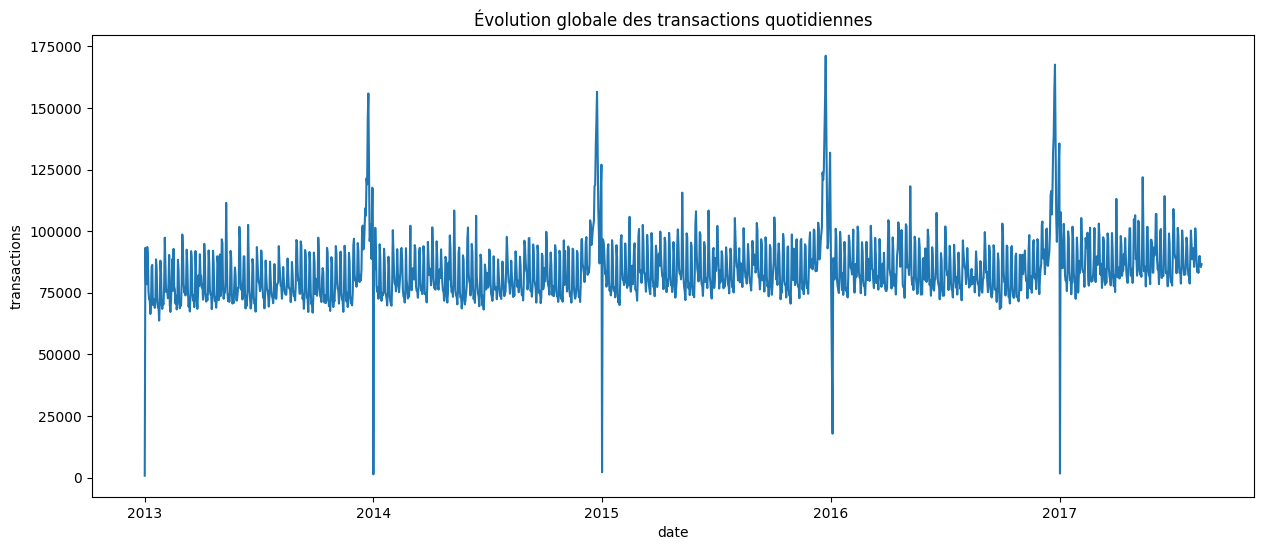

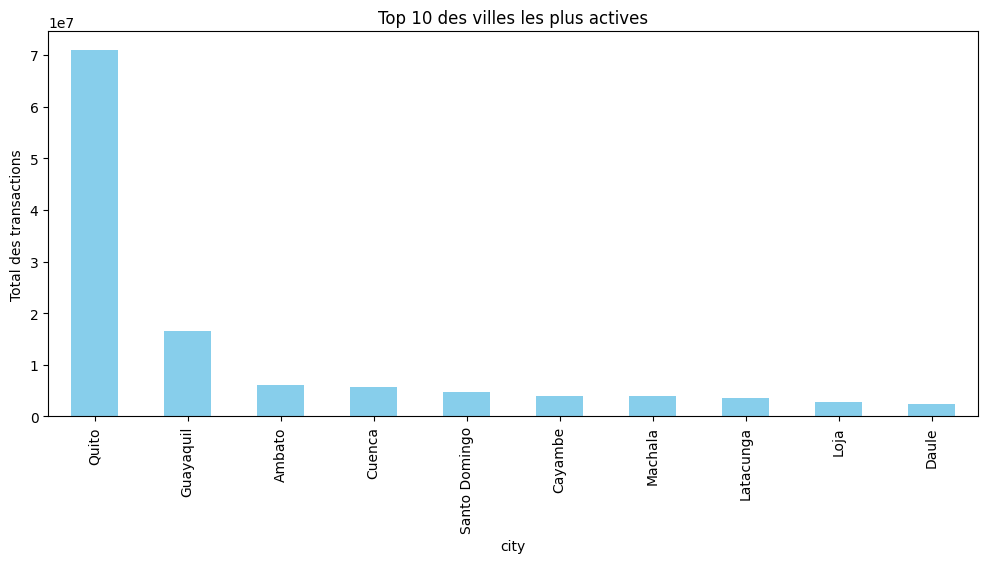

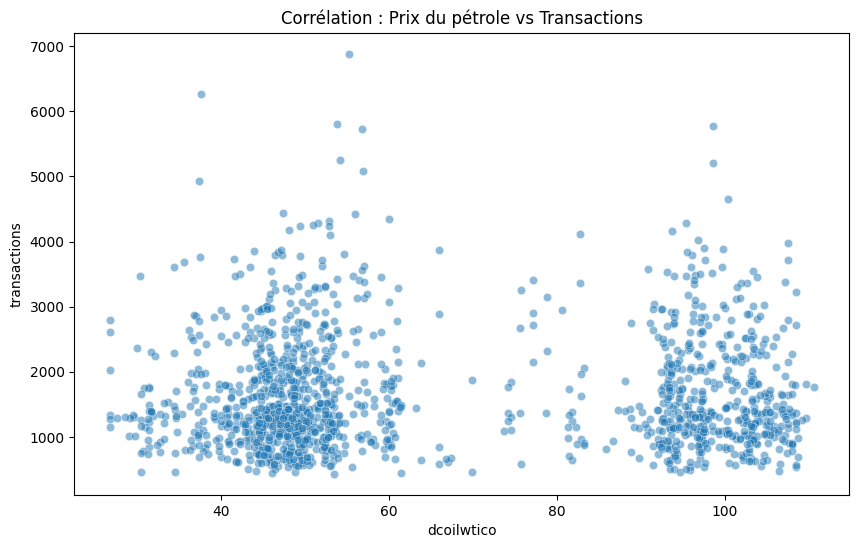

Analyse terminée. Prêt pour la modélisation.


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Chargement des données
# Assurez-vous d'avoir importé vos fichiers CSV dans le dossier de gauche sur Colab
stores = pd.read_csv('/datalab/stores.csv')
items = pd.read_csv('/datalab/items.csv')
oil = pd.read_csv('/datalab/oil.csv')
transactions = pd.read_csv('/datalab/transactions.csv')
holidays = pd.read_csv('/datalab/holidays_events.csv')

# Convertir les colonnes de date en format datetime
transactions['date'] = pd.to_datetime(transactions['date'])
oil['date'] = pd.to_datetime(oil['date'])
holidays['date'] = pd.to_datetime(holidays['date'])

# 2. Nettoyage : Remplir les valeurs manquantes pour le pétrole (interpolation)
oil['dcoilwtico'] = oil['dcoilwtico'].interpolate(method='linear', limit_direction='both')

# 3. Fusion des données (Transactions + Magasins + Pétrole)
df_merged = transactions.merge(stores, on='store_nbr', how='left')
df_merged = df_merged.merge(oil, on='date', how='left')

# Visualisation 1 : Évolution des transactions totales
plt.figure(figsize=(15, 6))
df_daily = df_merged.groupby('date')['transactions'].sum().reset_index()
sns.lineplot(data=df_daily, x='date', y='transactions')
plt.title('Évolution globale des transactions quotidiennes')
plt.show()

# Visualisation 2 : Top 10 des villes par nombre de transactions
plt.figure(figsize=(12, 5))
city_sales = df_merged.groupby('city')['transactions'].sum().sort_values(ascending=False).head(10)
city_sales.plot(kind='bar', color='skyblue')
plt.title('Top 10 des villes les plus actives')
plt.ylabel('Total des transactions')
plt.show()

# Visualisation 3 : Relation entre prix du pétrole et transactions
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_merged.sample(2000), x='dcoilwtico', y='transactions', alpha=0.5)
plt.title('Corrélation : Prix du pétrole vs Transactions')
plt.show()

print("Analyse terminée. Prêt pour la modélisation.")

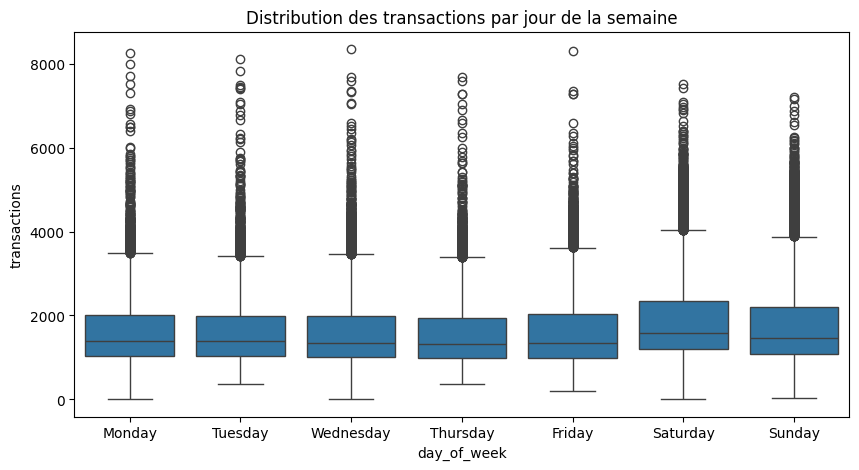

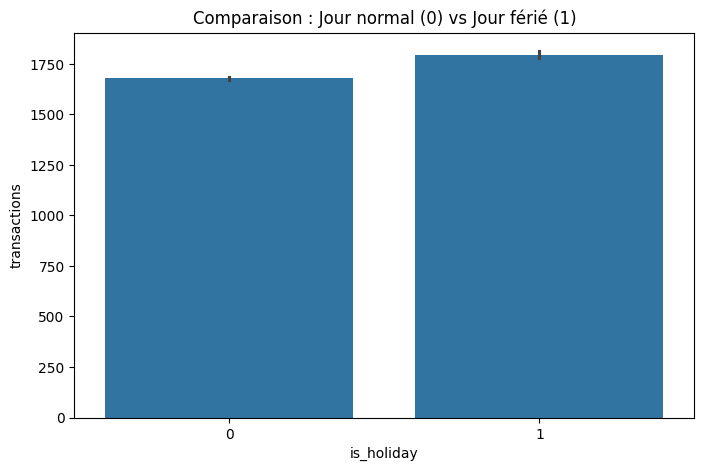

In [19]:
# Extraction de nouvelles caractéristiques temporelles
df_merged['day_of_week'] = df_merged['date'].dt.day_name()
df_merged['month'] = df_merged['date'].dt.month
df_merged['year'] = df_merged['date'].dt.year

# Visualisation 4 : Ventes par jour de la semaine
plt.figure(figsize=(10, 5))
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.boxplot(data=df_merged, x='day_of_week', y='transactions', order=order)
plt.title('Distribution des transactions par jour de la semaine')
plt.show()

# Visualisation 5 : Impact des jours fériés
# On marque les jours qui sont dans le fichier holidays
df_merged['is_holiday'] = df_merged['date'].isin(holidays['date']).astype(int)

plt.figure(figsize=(8, 5))
sns.barplot(data=df_merged, x='is_holiday', y='transactions')
plt.title('Comparaison : Jour normal (0) vs Jour férié (1)')
plt.show()

In [20]:
import plotly.express as px

# Dashboard interactif des transactions par type de magasin
fig = px.box(df_merged.sample(5000), x='type', y='transactions', color='cluster',
             title="Transactions par type de magasin et Cluster",
             hover_data=['city'])
fig.show()

# Evolution temporelle interactive
fig2 = px.line(df_daily, x='date', y='transactions', title='Graphique Interactif des Ventes')
fig2.show()

Le RMSE du modèle est de : 10053.02 transactions


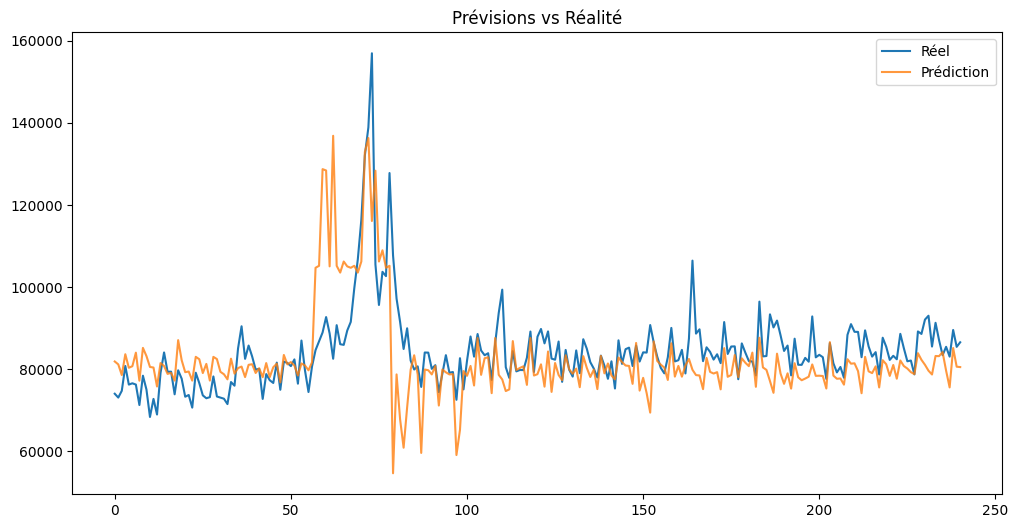

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Préparation des données pour le modèle
# On simplifie : on prédit les transactions globales quotidiennes
df_model = df_merged.groupby(['date', 'is_holiday', 'dcoilwtico']).transactions.sum().reset_index()
df_model['month'] = df_model['date'].dt.month
df_model['day_of_week'] = df_model['date'].dt.dayofweek

# Définir X (variables explicatives) et y (cible)
X = df_model[['is_holiday', 'dcoilwtico', 'month', 'day_of_week']]
y = df_model['transactions']

# Split Train/Test (on ne mélange pas au hasard pour les séries temporelles !)
split_point = int(len(X) * 0.8)
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

# Création et entraînement du modèle
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Prédiction et évaluation
predictions = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

print(f"Le RMSE du modèle est de : {rmse:.2f} transactions")

# Visualisation des résultats
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label='Réel')
plt.plot(predictions, label='Prédiction', alpha=0.8)
plt.legend()
plt.title("Prévisions vs Réalité")
plt.show()